<a href="https://colab.research.google.com/github/samiha-mahin/An-Image-Processing-Repo-/blob/main/Hot_Dog_vs_Not_Hot_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

TensorFlow has the food 101 dataset already. We will use this! https://www.tensorflow.org/datasets/catalog/food101

Hot dog is label 55

In [ ]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.QRRJ63_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.QRRJ63_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
def dataset_head(dataset,n=20):
   for i, (img,lbl) in enumerate(dataset.take(n),1):
     print(f"{i}. Label: {ds_info.features['label'].int2str(lbl)},Shape:{img.shape},Dtype:{img.dtype}") #int2str(lbl) just changes the number label into the actual class name

dataset_head(ds['train'])

1. Label: huevos_rancheros,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
2. Label: pizza,Shape:(384, 512, 3),Dtype:<dtype: 'uint8'>
3. Label: chocolate_cake,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
4. Label: miso_soup,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
5. Label: bruschetta,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
6. Label: pad_thai,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
7. Label: spaghetti_bolognese,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
8. Label: waffles,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
9. Label: chocolate_cake,Shape:(384, 512, 3),Dtype:<dtype: 'uint8'>
10. Label: hamburger,Shape:(384, 512, 3),Dtype:<dtype: 'uint8'>
11. Label: panna_cotta,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
12. Label: edamame,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
13. Label: filet_mignon,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
14. Label: chicken_quesadilla,Shape:(382, 512, 3),Dtype:<dtype: 'uint8'>
15. Label: beef_tartare,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
16. Label: pa

In the shape tuple `(height, width, 3)`, the **3** means **3 color channels** in the image.

That usually stands for **Red, Green, and Blue (RGB)** channels — which combine to create the full color image you see.

So:

* `(489, 512, 3)` means the image is 489 pixels tall, 512 pixels wide, and has 3 color channels (RGB).
* If it was `(512, 512, 1)`, that would be a grayscale image with just 1 channel.

In short, **3 = color image with RGB channels**!


In [ ]:
train_ds, valid_ds = ds["train"], ds["validation"]

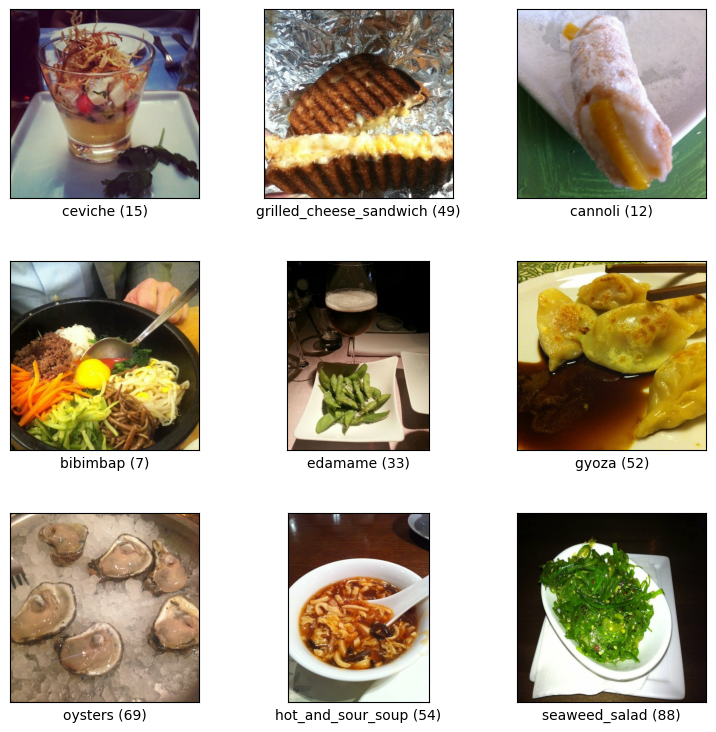

In [ ]:
fig = tfds.show_examples(valid_ds,ds_info)

In [ ]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55

def preprocess(image, label):
    # Resize image to 128x128 and convert pixel values to int32
    image_resized = tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN])
    image_resized = tf.cast(image_resized, tf.int32)

    # Check if label equals HOT_DOG_CLASS, convert result (True/False) to int32 (1 or 0)
    label_binary = tf.cast(label == HOT_DOG_CLASS, tf.int32)

    return image_resized, label_binary

train_ds = train_ds.map(preprocess)
valid_ds = valid_ds.map(preprocess)


* **`MAX_SIDE_LEN = 128`**
  We want all images to be 128 pixels wide and 128 pixels tall.

* **`HOT_DOG_CLASS = 55`**
  The class number 55 means "hot dog" in the Food101 dataset.

* **The `preprocess` function:**

  * It takes an image and its label.
  * It resizes the image to 128x128 pixels so all images are the same size.
  * It changes the image data type to integer numbers.
  * It checks if the label is the hot dog class (55).
  * If yes, it changes the label to 1; if no, it changes it to 0. So now, labels are just 0 or 1 (hot dog or not hot dog).

* **`train_ds.map(preprocess)` and `valid_ds.map(preprocess)`**
  This applies the above function to every image and label in the training and validation datasets.

**In short:**
You are making a dataset where every image is resized and labeled as either "hot dog" (1) or "not hot dog" (0), ready for a simple classification task.


In [16]:
train_hd_size, valid_hd_size = 750, 250

def split_hotdogs(dataset, repeat_times=1):
    hotdogs = dataset.filter(lambda _, label: label == 1).repeat(repeat_times)
    not_hotdogs = dataset.filter(lambda _, label: label == 0)
    return hotdogs, not_hotdogs

# Apply to train and valid
train_hotdogs, train_nothotdogs = split_hotdogs(train_ds, repeat_times=3)
valid_hotdogs, valid_nothotdogs = split_hotdogs(valid_ds, repeat_times=3)

valid_hotdogs


<_RepeatDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

1. **`train_hd_size, valid_hd_size = 750, 250`**
   Just storing the number of samples you want for training and validation.

2. **`split_hotdogs(dataset, repeat_times=1)` function**

   * **`hotdogs = dataset.filter(lambda _, label: label == 1)`** → keeps only hot dog images (label = 1).
   * **`.repeat(repeat_times)`** → repeats those hot dogs multiple times to balance the dataset.
   * **`not_hotdogs = dataset.filter(lambda _, label: label == 0)`** → keeps only non-hot dog images.
   * Returns both datasets.

3. **Apply to train and valid**

   * For training, repeat hot dogs **3 times**.
   * For validation, also repeat hot dogs **3 times**.

4. **`valid_hotdogs`**
   When you type this, it doesn’t show the images — it just tells you it’s a filtered TensorFlow dataset that contains only hot dogs from validation.

